# Analysing the data of the month August, using DBSCAN algorithm

# Importing required packages

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint

# Reading data

In [2]:
rides = pd.read_csv('./Uber-dataset/uber-raw-data-aug14.csv')
rides.head()

,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512
3,8/1/2014 0:12:00,40.7387,-73.9856,B02512
4,8/1/2014 0:12:00,40.7323,-74.0077,B02512


# Splitting the Date/Time column 

In [3]:
rides['Date/Time']= pd.to_datetime(rides['Date/Time'])
rides['month'] = rides['Date/Time'].dt.month
rides['day'] = rides['Date/Time'].dt.day
rides['hour'] = rides['Date/Time'].dt.hour
rides['minute'] = rides['Date/Time'].dt.minute

In [4]:
rides.head()

,Date/Time,Lat,Lon,Base,month,day,hour,minute
0,2014-08-01 00:03:00,40.7366,-73.9906,B02512,8,1,0,3
1,2014-08-01 00:09:00,40.7260,-73.9918,B02512,8,1,0,9
2,2014-08-01 00:12:00,40.7209,-74.0507,B02512,8,1,0,12
3,2014-08-01 00:12:00,40.7387,-73.9856,B02512,8,1,0,12
4,2014-08-01 00:12:00,40.7323,-74.0077,B02512,8,1,0,12


# plotting ride data

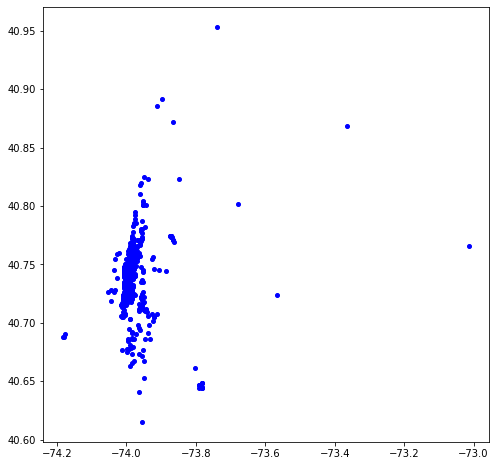

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

## get ride data
rides_this_hour = rides.loc[(rides['day']== 14) & (rides['hour'] == 22) & (rides['minute'] < 16)]

## plot ride data
plt.plot(rides_this_hour['Lon'], rides_this_hour['Lat'], 'bo', markersize=4)
plt.show()

The DBSCAN algorithm will group points together that meet a specified density metric. Basically, we'll define a maximum distance to make two individual points count as neighbors, as well as a minimum number of neighbors for a group of points to qualify as a cluster. The algorithm will sort the points into groups which meet the criteria and discard all of the outliers.

Once DBSCAN has identified all applicable clusters, we can easily calculate the centroid using the MultiPoint class from Shapely and plot the results.

This allows us to precisely identify locations which experience a high volume of pick-ups during a specified time frame. By using the total number of pickups in an individual cluster as a metric for coloring the hot spot locations, we can visualize the intensity of a given hot spot in addition to it's centroid.

First, we'll write a function which runs the clustering algorithm and returns the "hot spots." We'll get the coordinates of the centroid and the number of pick-ups in each cluster.

In [11]:
def get_hot_spots(max_distance,min_cars,ride_data):
    
    ## get coordinates from ride data
    #coords = ride_data.as_matrix(columns=['lat', 'lon'])
    coords = ride_data[['Lat', 'Lon']].to_numpy()
    
    ## calculate epsilon parameter using
    ## the user defined distance
    kms_per_radian = 6371.0088
    epsilon = max_distance / kms_per_radian
    
    ## perform clustering
    db = DBSCAN(eps=epsilon, min_samples=min_cars,
                algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
    ## group the clusters
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    
    ## report
    print('Number of clusters: {}'.format(num_clusters))
    
    ## initialize lists for hot spots
    Lat = []
    Lon = []
    num_members = []
    
    ## loop through clusters and get centroids, number of members
    for ii in range(len(clusters)):

        ## filter empty clusters
        if clusters[ii].any():

            ## get centroid and magnitude of cluster
            Lat.append(MultiPoint(clusters[ii]).centroid.x)
            Lon.append(MultiPoint(clusters[ii]).centroid.y)
            num_members.append(len(clusters[ii]))
            
    hot_spots = [Lon,Lat,num_members]
    
    return hot_spots

### locations which experience more than 25 pickups that occur within 50 meters of each other after 4:00 PM on August 14, 2014

In [12]:
## get ride data
ride_data = rides.loc[(rides['day']== 21) & (rides['hour'] > 15)]

## maximum distance between two cluster members in kilometers
max_distance = 0.05

## minimum number of cluster members
min_pickups = 25

## call the get_hot_spots function
hot_spots = get_hot_spots(max_distance ,min_pickups, ride_data)

Number of clusters: 56


### Now plot it up! This time we'll use a scatter plot so that we can set the marker color using the cluster size as a metric. 

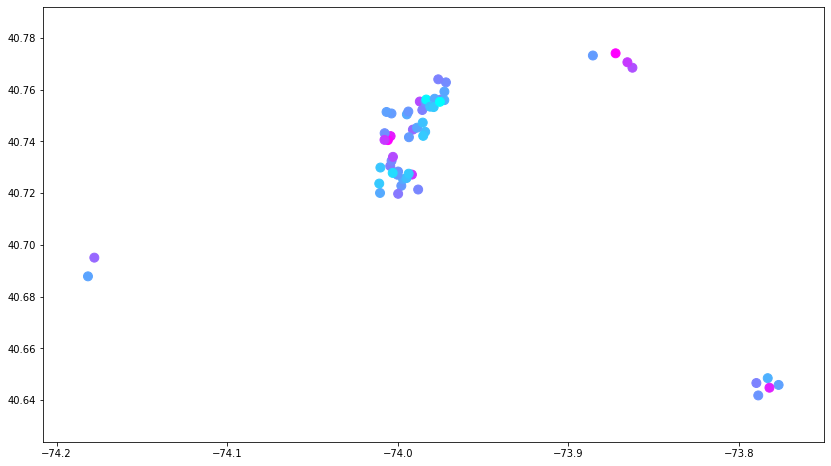

In [13]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
color_scale = np.log(hot_spots[2])
plt.scatter(hot_spots[0], hot_spots[1],s=80,c=color_scale,cmap=cm.cool)
plt.show()